<a href="https://colab.research.google.com/github/lydyang/HMS-Classification/blob/main/Spectrogram_AIT_Data_Science_HMS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **HMS - Harmful Brain Activity Classification**
Shirui Li, Falak Pabari, Lydia Yang, Echo Zhang

Challenge found [here](https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/overview).

# **Data Preparation - EEG & Spectrogram**

In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import numpy as np
import tensorflow as tf
import opendatasets as od
import random
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import configparser
import cv2
from configparser import ConfigParser
from pathlib import Path

from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, Activation, Conv1D, MaxPooling1D
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score

Input Kaggle username and API key when prompted:

username: "lydddddd"
password: "2ee9d5fcab6a9b81550b85c8d408d476"

In [ ]:
dataset = 'https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/data'
od.download(dataset)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: lydddddd
Your Kaggle Key: ··········


100%|██████████| 18.4G/18.4G [04:46<00:00, 68.9MB/s]



Extracting archive ./hms-harmful-brain-activity-classification/hms-harmful-brain-activity-classification.zip to ./hms-harmful-brain-activity-classification


In [ ]:
data_dir = './hms-harmful-brain-activity-classification'

In [ ]:
# Source: https://www.geeksforgeeks.org/python-get-unique-values-list/
def unique(list1):

    # insert the list to the set
    list_set = set(list1)
    # convert the set to the list
    unique_list = (list(list_set))
    return unique_list

In [ ]:
# Retrieve id names in a list for correlation
# id list format: eeg_id, spectrogram_id, patient_id, consensus
label_mapping = {
    'Seizure': 0,
    'LPD': 1,
    'GPD': 2,
    'LRDA': 3,
    'GRDA': 4,
    'Other': 5
}

train_csv = pd.read_csv(data_dir + '/train.csv')

eegids = train_csv['eeg_id'].tolist()
spectids = train_csv['spectrogram_id'].tolist()
patientids = train_csv['patient_id'].tolist()
consensus = [label_mapping[x] for x in train_csv['expert_consensus'].tolist()]
ids = unique(list(zip(eegids, spectids, patientids, consensus)))

In [ ]:
# Extract x and y datatet for spectrograms
rand_spectrogram = random.sample(ids, int(0.3*len(ids)))
spectrogram_dir = [(data_dir+"/"+"train_eegs/"+str(x[0])+".parquet") for x in rand_spectrogram]
x_spectrogram = [pd.read_parquet(file) for file in spectrogram_dir]
y_spectrogram = [x[3] for x in rand_spectrogram]
x_spectrogram[0]

,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,77.139999,61.480000,268.290009,55.160000,7.860000,37.980000,-13.360000,-31.209999,62.480000,58.610001,74.620003,100.389999,91.440002,71.930000,52.580002,100.400002,86.949997,77.029999,45.860001,-17.09
1,73.650002,61.540001,152.410004,60.529999,15.300000,41.029999,-6.600000,-24.990000,69.010002,63.119999,78.489998,92.400002,94.040001,75.230003,56.950001,103.150002,85.660004,78.110001,48.560001,-16.60
2,52.259998,70.489998,110.370003,63.029999,18.440001,46.610001,-2.250000,-23.410000,65.989998,61.939999,78.800003,92.040001,114.209999,73.190002,56.470001,97.820000,77.139999,81.580002,50.150002,-14.43
3,46.799999,62.139999,235.490005,55.080002,3.050000,24.320000,-12.560000,-29.910000,58.830002,55.540001,74.070000,75.400002,75.250000,69.580002,51.639999,97.400002,97.110001,77.870003,45.849998,-13.49
4,71.940002,73.199997,187.529999,63.520000,14.770000,52.240002,-7.370000,-25.700001,72.370003,68.589996,82.110001,46.830002,101.809998,84.519997,63.049999,104.820000,98.040001,81.790001,49.230000,-10.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10795,-9.800000,-1.880000,219.449997,-12.470000,-45.669998,-22.180000,-16.070000,-15.810000,-5.930000,-19.150000,10.020000,-16.969999,8.940000,-28.600000,-32.709999,-9.460000,-8.190000,-16.219999,-4.920000,-30.49
10796,9.230000,1.000000,207.669998,-15.030000,-20.670000,0.510000,-14.750000,-15.940000,-5.210000,-20.510000,8.630000,3.280000,-5.600000,-31.230000,-34.480000,-16.389999,-7.110000,-20.070000,-8.380000,-32.59
10797,-6.980000,11.860000,107.480003,-8.310000,-17.320000,-6.830000,-14.480000,-14.220000,10.100000,-8.780000,17.090000,1.350000,0.440000,-15.700000,-22.440001,-8.130000,15.820000,-12.870000,-2.590000,-33.09
10798,4.670000,7.730000,199.970001,-11.950000,-31.450001,-0.650000,-18.590000,-16.500000,5.850000,-19.150000,13.130000,-10.130000,-15.590000,-52.970001,-29.139999,5.920000,19.900000,-11.590000,-3.230000,-35.43


In [ ]:
rand_eeg = random.sample(ids, int(0.005*len(ids)))
eeg_dir = [(data_dir+"/"+"train_eegs/"+str(x[0])+".parquet") for x in rand_eeg]
x_eeg = [pd.read_parquet(file) for file in eeg_dir]
y_eeg = [x[3] for x in rand_eeg]
x_eeg[0]

,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,13.600000,4.410000,-3.11,0.52,-2.970000,0.780000,17.040001,22.330000,-61.500000,-60.040001,-28.500000,-31.790001,-55.020000,-63.849998,-59.139999,-32.130001,-33.470001,-23.889999,4.80,-10.97
1,15.070000,6.320000,-3.40,0.44,-2.890000,1.630000,16.590000,20.219999,-58.160000,-58.270000,-28.440001,-37.230000,-39.389999,-63.520000,-59.119999,-34.150002,-34.820000,-25.639999,3.91,-10.34
2,28.700001,9.490000,-1.13,3.61,0.460000,4.510000,15.860000,22.879999,-52.060001,-53.639999,-24.670000,-31.350000,-37.009998,-60.470001,-55.209999,-33.200001,-32.230000,-23.110001,6.39,-7.53
3,15.440000,10.150000,0.79,5.68,-0.130000,4.490000,19.240000,25.160000,-52.810001,-49.799999,-21.670000,-36.000000,-51.790001,-57.189999,-52.349998,-30.930000,-29.639999,-19.680000,9.65,-7.69
4,12.700000,6.840000,-0.63,4.03,-2.370000,2.920000,16.230000,22.889999,-57.080002,-52.459999,-23.700001,-40.160000,-40.990002,-60.220001,-55.029999,-32.560001,-31.930000,-22.330000,8.11,-6.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41595,-15.700000,-10.520000,-3.92,-5.83,-26.670000,-14.280000,4.280000,9.540000,-43.110001,-30.590000,-12.300000,-2.500000,-18.730000,-24.350000,-29.690001,-8.560000,-19.240000,-8.310000,13.93,-7.56
41596,-6.680000,-10.770000,-3.74,-4.08,-26.030001,-13.870000,4.790000,9.930000,-42.560001,-32.869999,-10.200000,6.130000,-24.549999,-24.660000,-28.120001,-9.840000,-19.900000,-10.330000,13.56,-6.53
41597,-15.410000,-15.420000,-4.61,-4.60,-29.200001,-14.820000,5.810000,9.840000,-44.930000,-32.299999,-9.140000,-2.370000,-25.150000,-24.389999,-26.520000,-9.460000,-18.440001,-7.780000,15.66,-8.59
41598,-26.340000,-19.139999,-7.68,-7.64,-33.470001,-18.700001,2.930000,8.210000,-51.480000,-34.430000,-12.030000,-11.780000,-27.870001,-27.690001,-28.540001,-13.450000,-22.030001,-9.460000,13.52,-9.90


1. histogram to see the distribution of the the first dimension
2. exclude outliers and find the max
3. 0 pad the rest accordign to the max (tensorflow/keras https://www.tensorflow.org/api_docs/python/tf/keras/layers/ZeroPadding1D)
4. pad the end of the sequence (right_pad).

In [ ]:
def get_array_1stdim(train_datatype):
  '''Get the first dimension data into an array. train_datatype should be egg or spectrogram'''
  list_1stdim = []

  for elem in train_datatype:
    list_1stdim.append(elem.shape[0])

  return np.array(list_1stdim)

In [ ]:
# Histogram
def get_array_1stdim(train_datatype):
  '''Get the first dimension data into an array. train_datatype should be egg or spectrogram'''
  list_1stdim = []

  for elem in train_datatype:
    list_1stdim.append(elem.shape[0])

  return np.array(list_1stdim)

def make_hist_part(array_1stdim, title):
  '''Plotting a histogram of the first dim data'''
  plt.hist(array_1stdim, bins=100, range=[0, 12000], color='skyblue', edgecolor='black')

  plt.xlabel('Values')
  plt.ylabel('Frequency')
  plt.title('Distribution of the First Dimension ' + title)

  plt.show()

def make_hist_whole(array_1stdim, title):
  '''Plotting a histogram of the first dim data'''
  plt.hist(array_1stdim, bins=100, color='skyblue', edgecolor='black')

  plt.xlabel('Values')
  plt.ylabel('Frequency')
  plt.title('Distribution of the First Dimension ' + title)

  plt.show()

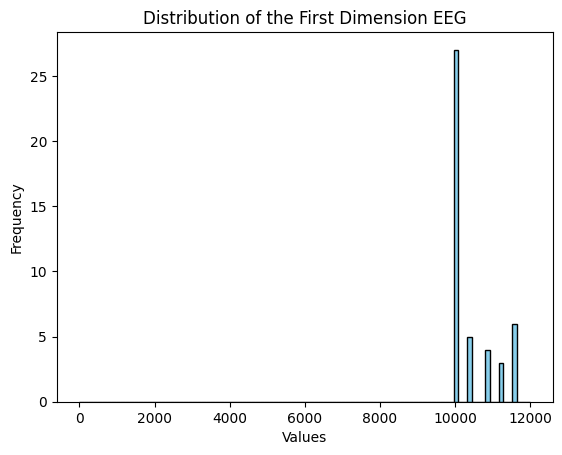

In [ ]:
make_hist_part(get_array_1stdim(x_eeg), "EEG")

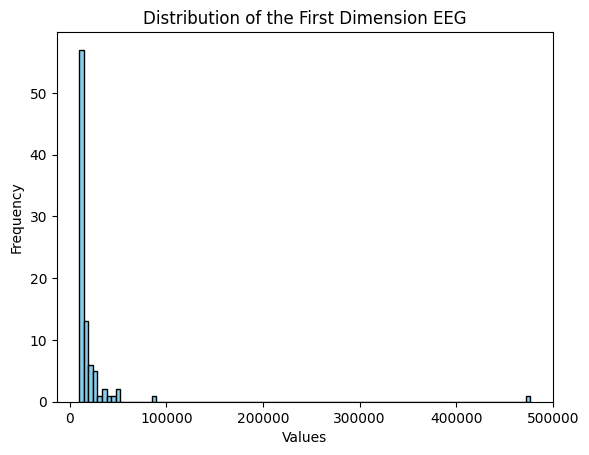

In [ ]:
make_hist_whole(get_array_1stdim(x_eeg), "EEG")

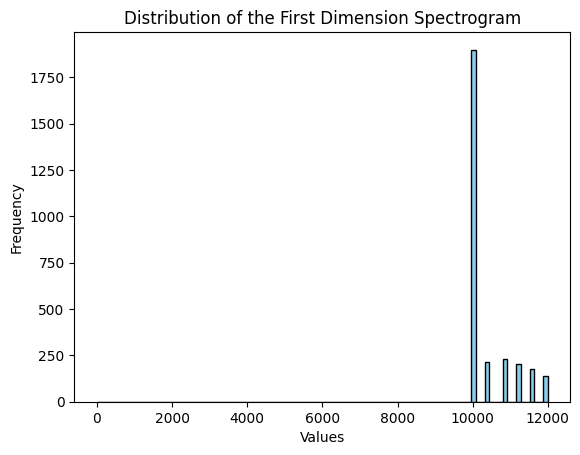

In [ ]:
make_hist_part(get_array_1stdim(x_spectrogram), "Spectrogram")

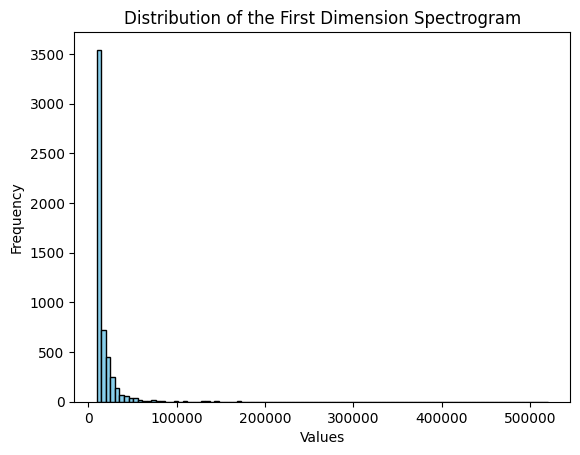

In [ ]:
make_hist_whole(get_array_1stdim(x_spectrogram), "Spectrogram")

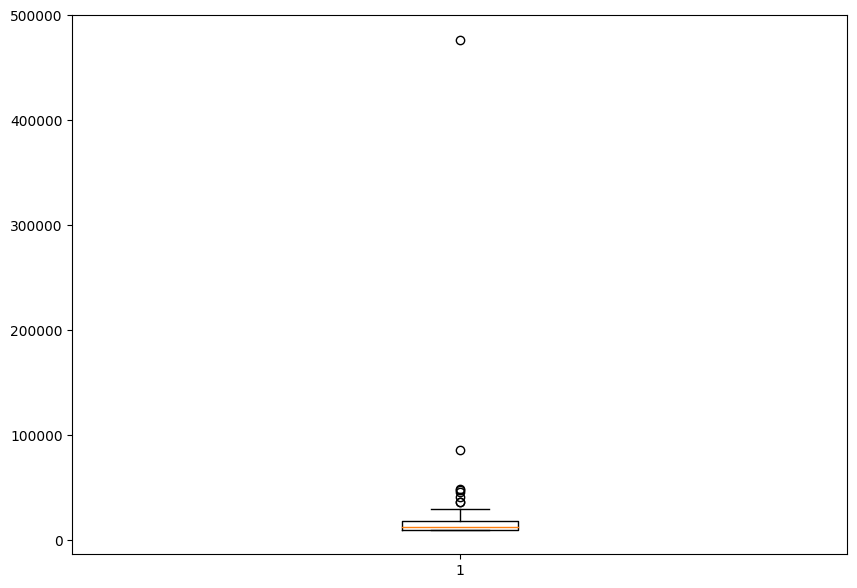

In [ ]:
# Boxplot
def make_boxplot(array_1stdim):
  '''Making a boxplot of the first dim data'''
  fig = plt.figure(figsize =(10, 7))

  plt.boxplot(array_1stdim)

  plt.show()
make_boxplot(get_array_1stdim(x_eeg))

In [ ]:
def trim(value, x, y):
  new_x = []
  new_y = []

  # make new traiin
  for i in range(len(x)):
    if x[i].shape[0] <= value:
      new_x.append(x[i])
      new_y.append(y[i])

  return new_x, new_y

In [ ]:
x_eeg, y_eeg = trim(10000, x_eeg, y_eeg)

In [ ]:
print(x_eeg[0], y_eeg[0])

            Fp1         F3         C3         P3     F7         T3         T5  \
0     27.650000 -20.740000 -57.689999 -40.410000  -9.84 -26.049999 -34.029999   
1     31.370001 -19.410000 -57.950001 -40.139999  -8.77 -26.580000 -33.759998   
2     14.620000 -26.850000 -59.549999 -41.740002 -10.90 -26.049999 -35.360001   
3     19.940001 -23.660000 -58.220001 -41.200001 -10.90 -26.850000 -34.290001   
4     32.430000 -19.410000 -57.419998 -39.880001  -8.51 -26.580000 -34.029999   
...         ...        ...        ...        ...    ...        ...        ...   
9995   5.580000 -20.469999 -52.639999 -27.910000  -8.77 -22.860001 -26.850000   
9996  18.080000 -16.480000 -51.840000 -27.120001  -8.24 -23.930000 -26.580000   
9997  15.950000 -18.870001 -53.169998 -27.379999 -10.10 -24.459999 -26.850000   
9998  -5.320000 -26.580000 -55.560001 -29.770000 -13.56 -25.520000 -27.910000   
9999  10.370000 -22.059999 -53.970001 -29.510000 -11.43 -26.049999 -28.180000   

         O1         Fz     

In [ ]:
print(len(x_eeg))

27


In [ ]:
x_spectrogram, y_spectrogram = trim(10000, x_spectrogram, y_spectrogram)

# **Splitting Train-Test Dataset - EEG**

In [ ]:
for L in x_eeg:
  L.fillna(0,inplace=True)

In [ ]:
train_ratio  = 0.8
train_length = len(x_eeg) # length of the training data
print(train_length)
train_split  = int(train_length*train_ratio) # where to split the training and validation data
print(train_split)
temp_x_train_eeg, temp_y_train_eeg = x_eeg[:train_split], y_eeg[:train_split]
print(len(temp_x_train_eeg), len(temp_y_train_eeg))
x_test_eeg, y_test_eeg = x_eeg[train_split:], y_eeg[train_split:]
print(len(x_test_eeg), len(y_test_eeg))

27
21
21 21
6 6


In [ ]:
train_ratio  = 0.8
train_length = len(temp_x_train_eeg) # length of the training data
print(train_length)
train_split  = int(train_length*train_ratio) # where to split the training and validation data
print(train_split)
x_train_eeg, y_train_eeg = temp_x_train_eeg[:train_split], temp_y_train_eeg[:train_split]
print(len(x_train_eeg), len(y_train_eeg))
x_valid_eeg, y_valid_eeg = temp_x_train_eeg[train_split:], temp_y_train_eeg[train_split:]
print(len(x_valid_eeg), len(y_valid_eeg))

21
16
16 16
5 5


In [ ]:
x_valid_eeg[0]

,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,148.979996,146.529999,130.020004,126.500000,173.369995,125.739998,104.699997,96.930000,94.830002,149.339996,138.860001,88.910004,81.220001,120.320000,126.559998,58.349998,79.889999,93.559998,107.959999,-441.970001
1,154.850006,169.990005,157.050003,166.020004,198.279999,154.889999,156.820007,136.779999,112.160004,182.080002,159.270004,98.709999,117.000000,143.089996,150.970001,82.919998,128.660004,142.199997,138.080002,-71.089996
2,161.479996,166.880005,159.399994,146.059998,207.899994,169.570007,130.470001,122.040001,109.250000,159.000000,170.649994,102.370003,84.620003,142.500000,157.820007,99.400002,94.480003,123.150002,137.369995,-173.630005
3,187.440002,177.860001,166.990005,157.529999,215.649994,174.520004,141.820007,132.279999,118.830002,169.619995,178.039993,130.020004,86.769997,145.679993,165.789993,103.639999,98.610001,127.550003,147.970001,-477.399994
4,183.880005,182.460007,166.910004,178.009995,217.580002,171.979996,171.119995,155.690002,118.040001,185.220001,170.869995,126.919998,112.339996,140.509995,164.270004,112.540001,135.529999,160.630005,160.449997,-210.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,65.660004,46.799999,15.990000,5.030000,64.209999,43.950001,12.130000,-8.300000,34.439999,13.300000,5.930000,72.070000,20.059999,4.180000,8.300000,33.139999,4.760000,2.930000,0.420000,-285.239990
9996,35.970001,38.639999,7.500000,18.010000,46.730000,29.490000,36.110001,10.080000,22.340000,22.610001,-4.920000,48.299999,35.130001,-4.330000,2.160000,13.590000,30.040001,24.080000,5.930000,-9.980000
9997,31.879999,32.279999,3.930000,6.950000,45.520000,33.459999,23.780001,-0.210000,17.520000,9.860000,-4.140000,41.980000,22.160000,-3.970000,0.940000,8.820000,16.420000,16.540001,0.870000,-19.830000
9998,51.820000,35.750000,4.800000,-3.700000,53.070000,36.849998,1.200000,-14.540000,25.379999,2.250000,2.500000,56.930000,10.300000,-0.160000,3.940000,26.379999,-3.760000,-2.970000,-4.990000,-268.040009


In [ ]:
x_train_eeg = np.array(x_train_eeg)
x_test_eeg = np.array(x_test_eeg)
x_valid_eeg = np.array(x_valid_eeg)

y_train_eeg = np.array(y_train_eeg)
y_test_eeg = np.array(y_test_eeg)
y_valid_eeg = np.array(y_valid_eeg)

In [ ]:
mean = x_train_eeg.mean(axis=0)
std  = x_train_eeg.std(axis=0)
x_train_eeg = (x_train_eeg-mean)/std
x_valid_eeg = (x_valid_eeg-mean)/std
x_test_eeg  = (x_test_eeg-mean)/std

In [ ]:
print(mean,std)

[[1321.3444   1340.9081   1304.1213   ... 1254.3643   1261.
   -65.06125 ]
 [ 944.005     874.12506   890.4037   ...  937.2694    940.375
    22.559376]
 [ 758.5737    832.98816   823.935    ...  701.7987    701.80743
    86.66688 ]
 ...
 [1061.2068   1050.3987   1021.1005   ... 1005.39185   973.7975
    91.82937 ]
 [1174.453    1184.9745   1269.2235   ... 1307.5806   1343.5795
  -131.49686 ]
 [1136.286    1119.7292   1079.5599   ... 1070.0443   1054.3776
    55.465626]] [[5099.542   5232.1636  4955.419   ... 4717.2236  4599.041    365.11197]
 [3642.7363  3443.0312  3545.352   ... 3779.5105  3840.0762   126.12616]
 [2957.4458  3292.6038  3432.627   ... 3143.5781  3235.2473   336.6969 ]
 ...
 [4201.6865  4168.446   4205.8403  ... 4328.34    4371.5884   253.95299]
 [4583.4385  4649.3374  4891.4854  ... 5074.357   5158.517    471.32892]
 [4538.348   4493.595   4159.8984  ... 4001.2546  3898.1106   345.3937 ]]


In [ ]:
# Ensure there are no NaNs or infinite values
print("NaNs in x_eeg:", np.isnan(x_eeg).any())
print("Infs in x_eeg:", np.isinf(x_eeg).any())
print("NaNs in y_eeg:", np.isnan(y_eeg).any())
print("Infs in y_eeg:", np.isinf(y_eeg).any())

NaNs in x_eeg: False
Infs in x_eeg: False
NaNs in y_eeg: False
Infs in y_eeg: False


In [ ]:
for i in x_eeg:
    i = np.nan_to_num(i, nan=0.0)
    # if True in np.isnan(i):
    #     print(f"NaN/Inf found in sample {i}")

In [ ]:
from collections import Counter
thing = y_train_eeg.tolist()
values, counts = np.unique(thing, return_counts=True)
print(values)
print(counts)

[0 1 3 4 5]
[1 4 1 1 9]


In [ ]:
nb_classes = len(np.unique(y_train_eeg))
print(nb_classes)
nb_classes = 6
y_train_eeg = to_categorical(y_train_eeg, nb_classes)
y_valid_eeg = to_categorical(y_valid_eeg, nb_classes)
y_test_eeg  = to_categorical(y_test_eeg, nb_classes)

5


# **Training the Model - EEG**

In [ ]:
x_train_eeg.shape

(16, 10000, 20)

In [ ]:
y_train_eeg.shape

(16, 6)

In [ ]:
# Early Stopping Method
es = EarlyStopping(patience = 5, monitor = 'val_accuracy', restore_best_weights=True)
rate = 0.1

In [ ]:
nb_filter       = 3   # number of filter/kernels in the convolutional layers
filter_length   = 5  # length of the filter/kernel in the convolutional layers
window_size     = x_train_eeg.shape[1] # the window size defined by the dataset
nb_features     = x_train_eeg.shape[2] # the number of features of the input data (number of dimensions)
nb_outputs      = y_train_eeg.shape[1] # the number of outputs (defined by the target data)

In [ ]:
model = Sequential()

# First convolutional block
model.add(Conv1D(filters=nb_filter*3, kernel_size=filter_length, activation='relu', kernel_initializer='he_normal', input_shape=(window_size, nb_features)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2, strides=2, padding="valid"))
model.add(Dropout(rate))

# Second convolutional block
model.add(Conv1D(filters=nb_filter*3, kernel_size=filter_length, activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Dropout(rate))

# Third convolutional block (additional layer)
model.add(Conv1D(filters=nb_filter*3, kernel_size=filter_length, activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Dropout(rate))

# Flatten and fully connected layers
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Dropout(rate))
model.add(Dense(nb_outputs, activation='softmax', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(0.01)))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
network_history = model.fit(x_train_eeg, y_train_eeg,
                            validation_data=(x_valid_eeg,y_valid_eeg),
                            batch_size=16,
                            epochs=100,
                            verbose=1,
                            callbacks=[es])

Epoch 1/100
1/1 [==============================] - 9s 9s/step - loss: 5.1843 - accuracy: 0.1250 - val_loss: 10.0386 - val_accuracy: 0.4000
Epoch 2/100
1/1 [==============================] - 0s 71ms/step - loss: 5.3939 - accuracy: 0.6250 - val_loss: 13.3327 - val_accuracy: 0.4000
Epoch 3/100
1/1 [==============================] - 0s 67ms/step - loss: 3.0644 - accuracy: 0.8125 - val_loss: 15.9357 - val_accuracy: 0.4000
Epoch 4/100
1/1 [==============================] - 0s 90ms/step - loss: 3.4228 - accuracy: 0.8125 - val_loss: 18.0793 - val_accuracy: 0.4000
Epoch 5/100
1/1 [==============================] - 0s 81ms/step - loss: 2.7952 - accuracy: 0.9375 - val_loss: 19.6532 - val_accuracy: 0.4000
Epoch 6/100
1/1 [==============================] - 0s 101ms/step - loss: 2.8126 - accuracy: 0.9375 - val_loss: 20.6347 - val_accuracy: 0.4000


# **Evaluation - EEG**

In [ ]:
x_test_eeg.shape

(6, 10000, 20)

In [ ]:
y_test_eeg.shape

(6, 6)

In [ ]:
eval = model.evaluate(x_test_eeg,y_test_eeg)
print("Test loss:",eval[0])
print("Test accuracy:",eval[1])

1/1 [==============================] - 0s 157ms/step - loss: 11.8549 - accuracy: 0.6667
Test loss: 11.854876518249512
Test accuracy: 0.6666666865348816


In [ ]:
preds = model.predict(x_test_eeg)

1/1 [==============================] - 0s 167ms/step


In [ ]:
print(classification_report(np.argmax(y_test_eeg,1),np.argmax(preds,1)))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           5       0.67      1.00      0.80         4

    accuracy                           0.67         6
   macro avg       0.22      0.33      0.27         6
weighted avg       0.44      0.67      0.53         6



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
balanced_accuracy_score(np.argmax(y_test_eeg,1),np.argmax(preds,1))

0.3333333333333333

<Axes: >

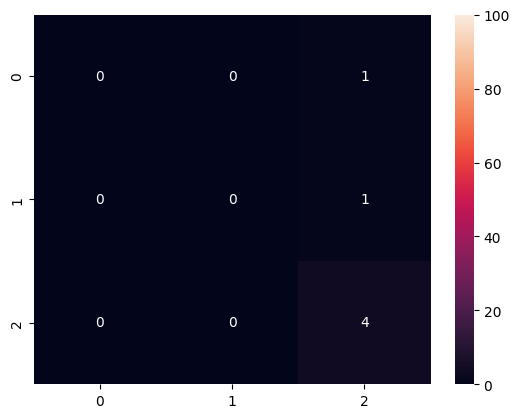

In [ ]:
conf=confusion_matrix(np.argmax(y_test_eeg,1),np.argmax(preds,1))
sns.heatmap(conf, annot=True, fmt='d', vmax=100)

# **Splitting Train-Test Dataset - Spectrogram**

In [ ]:
for L in x_spectrogram:
  L.fillna(0,inplace=True)

In [ ]:
train_ratio  = 0.8
train_length = len(x_spectrogram) # length of the training data
print(train_length)
train_split  = int(train_length*train_ratio) # where to split the training and validation data
print(train_split)
temp_x_train_spectrogram, temp_y_train_spectrogram = x_spectrogram[:train_split], y_spectrogram[:train_split]
print(len(temp_x_train_spectrogram), len(temp_y_train_spectrogram))
x_test_spectrogram, y_test_spectrogram = x_spectrogram[train_split:], y_spectrogram[train_split:]
print(len(x_test_spectrogram), len(y_test_spectrogram))

1899
1519
1519 1519
380 380


In [ ]:
train_ratio  = 0.8
train_length = len(temp_x_train_spectrogram) # length of the training data
print(train_length)
train_split  = int(train_length*train_ratio) # where to split the training and validation data
print(train_split)
x_train_spectrogram, y_train_spectrogram = temp_x_train_spectrogram[:train_split], temp_y_train_spectrogram[:train_split]
print(len(x_train_spectrogram), len(y_train_spectrogram))
x_valid_spectrogram, y_valid_spectrogram = temp_x_train_spectrogram[train_split:], temp_y_train_spectrogram[train_split:]
print(len(x_valid_spectrogram), len(y_valid_spectrogram))

1519
1215
1215 1215
304 304


In [ ]:
x_train_spectrogram = np.array(x_train_spectrogram)
x_test_spectrogram = np.array(x_test_spectrogram)
x_valid_spectrogram = np.array(x_valid_spectrogram)

y_train_spectrogram = np.array(y_train_spectrogram)
y_test_spectrogram = np.array(y_test_spectrogram)
y_valid_spectrogram = np.array(y_valid_spectrogram)

In [ ]:
y_train_spectrogram

array([5, 1, 5, ..., 0, 5, 5])

In [ ]:
thing = y_train_spectrogram.tolist()
values, counts = np.unique(thing, return_counts=True)
print(values)
print(counts)

[0 1 2 3 4 5]
[ 81 171 124  35 103 701]


In [ ]:
# nb_classes = len(np.unique(y_train_spectrogram))
nb_classes = 6
print(nb_classes)
y_train_spectrogram = to_categorical(y_train_spectrogram, nb_classes)
y_valid_spectrogram = to_categorical(y_valid_spectrogram, nb_classes)
y_test_spectrogram  = to_categorical(y_test_spectrogram, nb_classes)

6


# **Training the Model - Spectrogram**

In [ ]:
x_train_spectrogram.shape

(1215, 10000, 20)

In [ ]:
y_train_spectrogram.shape

(1215, 6)

In [ ]:
# Early Stopping Method
es = EarlyStopping(patience = 5, monitor = 'val_accuracy', restore_best_weights=True)
rate = 0.1

In [ ]:
nb_filter       = 3   # number of filter/kernels in the convolutional layers
filter_length   = 5  # length of the filter/kernel in the convolutional layers
window_size     = x_train_spectrogram.shape[1] # the window size defined by the dataset
nb_features     = x_train_spectrogram.shape[2] # the number of features of the input data (number of dimensions)
nb_outputs      = y_train_spectrogram.shape[1] # the number of outputs (defined by the target data)

In [ ]:
model = Sequential()

# First convolutional block
model.add(Conv1D(filters=nb_filter*3, kernel_size=filter_length, activation='relu', kernel_initializer='he_normal', input_shape=(window_size, nb_features)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2, strides=2, padding="valid"))
model.add(Dropout(rate))

# Second convolutional block
model.add(Conv1D(filters=nb_filter*3, kernel_size=filter_length, activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Dropout(rate))

# Third convolutional block (additional layer)
model.add(Conv1D(filters=nb_filter*3, kernel_size=filter_length, activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Dropout(rate))

# Flatten and fully connected layers
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(Dropout(rate))
model.add(Dense(nb_outputs, activation='softmax', kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.l2(0.01)))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
network_history = model.fit(x_train_spectrogram, y_train_spectrogram,
                            validation_data=(x_valid_spectrogram, y_valid_spectrogram),
                            batch_size=32,
                            epochs=100,
                            verbose=1,
                            callbacks=[es])

Epoch 1/100
38/38 [==============================] - 6s 61ms/step - loss: 6.0390 - accuracy: 0.4519 - val_loss: 8.6232 - val_accuracy: 0.4539
Epoch 2/100
38/38 [==============================] - 1s 33ms/step - loss: 4.8184 - accuracy: 0.5391 - val_loss: 5.4650 - val_accuracy: 0.4770
Epoch 3/100
38/38 [==============================] - 1s 30ms/step - loss: 3.8288 - accuracy: 0.5621 - val_loss: 3.8088 - val_accuracy: 0.5526
Epoch 4/100
38/38 [==============================] - 1s 29ms/step - loss: 3.4115 - accuracy: 0.5671 - val_loss: 3.4501 - val_accuracy: 0.5197
Epoch 5/100
38/38 [==============================] - 1s 34ms/step - loss: 3.0298 - accuracy: 0.5918 - val_loss: 3.6778 - val_accuracy: 0.2007
Epoch 6/100
38/38 [==============================] - 1s 31ms/step - loss: 2.7688 - accuracy: 0.5770 - val_loss: 3.0710 - val_accuracy: 0.3125
Epoch 7/100
38/38 [==============================] - 1s 30ms/step - loss: 2.5220 - accuracy: 0.5835 - val_loss: 3.3317 - val_accuracy: 0.2862
Epoch 

# **Evaluation - Spectrogram**

In [ ]:
x_test_spectrogram.shape

(380, 10000, 20)

In [ ]:
y_test_spectrogram.shape

(380, 6)

In [ ]:
eval = model.evaluate(x_test_spectrogram,y_test_spectrogram)
print("Test loss:",eval[0])
print("Test accuracy:",eval[1])

12/12 [==============================] - 0s 37ms/step - loss: 3.9664 - accuracy: 0.5553
Test loss: 3.9663946628570557
Test accuracy: 0.5552631616592407


In [ ]:
preds = model.predict(x_test_spectrogram)

12/12 [==============================] - 0s 15ms/step


In [ ]:
print(classification_report(np.argmax(y_test_spectrogram,1),np.argmax(preds,1)))

              precision    recall  f1-score   support

           0       0.17      0.07      0.10        27
           1       0.29      0.05      0.09        38
           2       0.20      0.05      0.08        41
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00        31
           5       0.59      0.90      0.71       228

    accuracy                           0.56       380
   macro avg       0.21      0.18      0.16       380
weighted avg       0.42      0.56      0.45       380



In [ ]:
balanced_accuracy_score(np.argmax(y_test_spectrogram,1),np.argmax(preds,1))

0.1791014913073107

<Axes: >

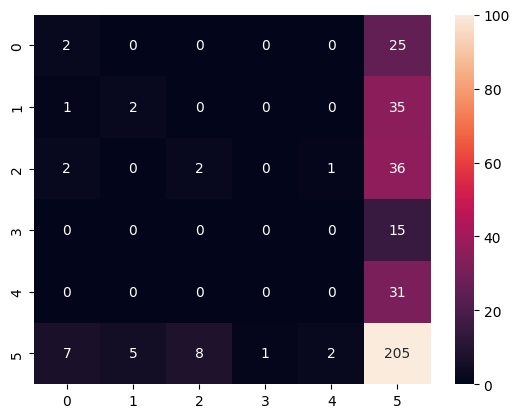

In [ ]:
conf=confusion_matrix(np.argmax(y_test_spectrogram,1),np.argmax(preds,1))
sns.heatmap(conf, annot=True, fmt='d', vmax=100)